In [26]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_dir = "./dataset/images/train/"
sub_folders = os.listdir(data_dir)

In [3]:
images = []
labels = []

for sub_folder in sub_folders:
    label = sub_folder

    path = os.path.join(data_dir, sub_folder)

    sub_folder_images = os.listdir(path)

    for image_name in sub_folder_images:
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
        images.append(img)
        labels.append(label)
        
images = np.array(images)
labels = np.array(labels)
print(len(images))

28821


In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
print("X_train_full data: ", len(X_train_full))
print("X_test data: ", len(X_test))

X_train_full data:  23056
X_test data:  5765


In [6]:
print("X_train data: ", len(X_train))
print("X_val data: ", len(X_val))

X_train data:  18444
X_val data:  4612


In [7]:
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)

In [8]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [9]:
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10
)

data_gen.fit(X_train)

label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [10]:
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [11]:
num_classes = len(label_encoder.classes_)

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)

In [12]:
model = Sequential()
model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\kvist\anaconda3\envs\djuplearninng\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 4,348,679 (16.59 MB)

 Trainable params: 4,344,711 (16.57 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [13]:
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/50


c:\Users\kvist\anaconda3\envs\djuplearninng\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


145/145 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.1881 - loss: 2.4229 - val_accuracy: 0.1745 - val_loss: 2.4367 - learning_rate: 0.0010
Epoch 2/50


c:\Users\kvist\anaconda3\envs\djuplearninng\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.2327 - loss: 1.9812 - val_accuracy: 0.2511 - val_loss: 2.1632 - learning_rate: 0.0010
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.2735 - loss: 1.8391 - val_accuracy: 0.2016 - val_loss: 2.2058 - learning_rate: 0.0010
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.3329 - loss: 1.7241 - val_accuracy: 0.2936 - val_loss: 2.2972 - learning_rate: 0.0010
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.3710 - loss: 1.6196 - val_accuracy: 0.2890 - val_loss: 2.0169 - learning_rate: 0.0010
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.4029 - loss: 1.5387 - val_accuracy: 0.4252 - val_loss: 1.4693 - learning_rate: 0.0010
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4350 - loss: 1.4725 - val_accuracy: 0.4018 - val_loss: 1.6973 - learning_rate: 0.0010
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.4633 - loss: 1.4066 - val_

In [15]:
model.save('model.h5')

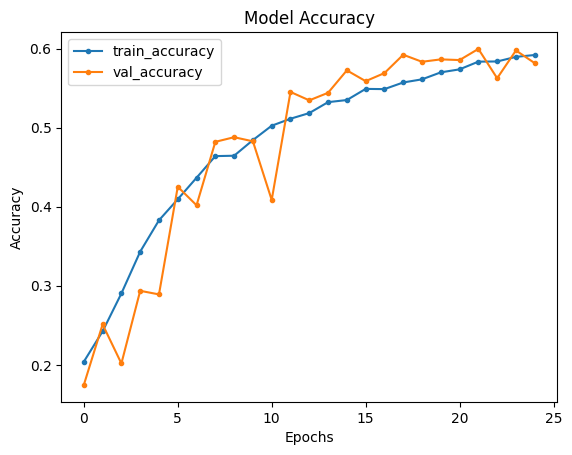

In [19]:
plt.plot(history.history['accuracy'], label='train_accuracy', marker='.')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='.')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
model = load_model('model.h5')

In [42]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred_labels == y_test)
print(f"Accuracy: {accuracy}")



181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step
Accuracy: 0.596357328707719


In [43]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
print(classification_report(y_test, y_pred_labels, target_names=emotion_labels))

              precision    recall  f1-score   support

       Angry       0.54      0.38      0.45       769
     Disgust       0.52      0.32      0.40        93
        Fear       0.53      0.27      0.35       823
       Happy       0.79      0.86      0.82      1507
     Neutral       0.51      0.62      0.56       993
         Sad       0.41      0.60      0.49       955
    Surprise       0.79      0.67      0.73       625

    accuracy                           0.60      5765
   macro avg       0.58      0.53      0.54      5765
weighted avg       0.60      0.60      0.59      5765



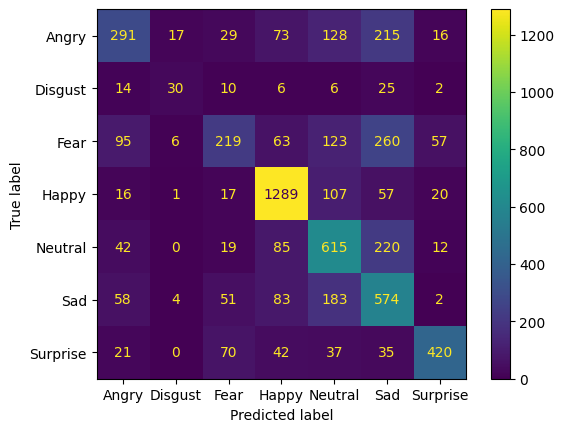

In [44]:
cm_test = confusion_matrix(y_test, y_pred_labels)
ConfusionMatrixDisplay(cm_test, display_labels=emotion_labels).plot()